
# Ex 7. Structure-Constrained Time-Lapse Resistivity Inversion

This example combines structural constraints with time-lapse ERT inversion
to monitor water content changes in layered geological media.

The workflow demonstrates:
1. Loading meshes with geological structure from seismic interpretation
2. Time-lapse ERT inversion with structural constraints
3. Converting resistivity to water content using layer-specific petrophysics
4. Uncertainty quantification through Monte Carlo analysis
5. Time series analysis of water content at specific locations

This advanced approach provides the most reliable estimates of subsurface
water content evolution by combining temporal, spatial, and geological
constraints in the inversion process.


In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import pygimli as pg
from pygimli.physics import ert
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Setup package path for development
try:
    # For regular Python scripts
    current_dir = os.path.dirname(os.path.abspath(__file__))
except NameError:
    # For Jupyter notebooks
    current_dir = os.getcwd()

# Add the parent directory to Python path
parent_dir = os.path.dirname(current_dir)
if parent_dir not in sys.path:
    sys.path.append(parent_dir)

# Import PyHydroGeophysX modules
from PyHydroGeophysX.inversion.time_lapse import TimeLapseERTInversion
from PyHydroGeophysX.inversion.windowed import WindowedTimeLapseERTInversion

In [2]:
data_dir = "results/TL_measurements/appres"

# List of ERT data files testing monthly time-lapse inversion
ert_files = [
    "synthetic_data30.dat",
    "synthetic_data60.dat",
    "synthetic_data90.dat",
    "synthetic_data120.dat",
    "synthetic_data150.dat",
    "synthetic_data180.dat",
    "synthetic_data210.dat",
    "synthetic_data240.dat",
    "synthetic_data270.dat",
    "synthetic_data300.dat",
    "synthetic_data330.dat",
    "synthetic_data360.dat",
]


# Full paths to data files
data_files = [os.path.join(data_dir, f) for f in ert_files]

# Measurement times (can be timestamps or any sequential numbers representing time)
# Measurement times (can be timestamps or any sequential numbers representing time)
measurement_times = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]  # Adjust based on your actual acquisition times

# Create a mesh for the inversion (or load an existing one)
data = ert.load(os.path.join(data_dir, ert_files[0]))
ert_manager = ert.ERTManager(data)
mesh_with_interface = pg.load("C:/Users/HChen8/Documents/GitHub/PyHydroGeophysX/examples/results/Structure_WC/mesh_with_interface.bms")

Exception: File or directory named results/TL_measurements/appres\synthetic_data30.dat does not exist.

In [3]:
# Set up inversion parameters
inversion_params = {
    "lambda_val": 10.0,              # Regularization parameter
    "alpha": 10.0,                   # Temporal regularization parameter
    "decay_rate": 0.0,               # Temporal decay rate
    "method": "cgls",                # Solver method ('cgls', 'lsqr', etc.)
    "model_constraints": (0.001, 1e4), # Min/max resistivity values (ohm-m)
    "max_iterations": 15,            # Maximum iterations
    "absoluteUError": 0.0,           # Absolute data error (V)
    "relativeError": 0.05,           # Relative data error (5%)
    "lambda_rate": 1.0,              # Lambda reduction rate
    "lambda_min": 1.0,               # Minimum lambda value
    "inversion_type": "L2"           # 'L1', 'L2', or 'L1L2'
}

# Define the window size (number of timesteps to process together)
window_size = 3  # A window size of 3 means each window includes 3 consecutive measurements

# Create the windowed time-lapse inversion object
inversion = WindowedTimeLapseERTInversion(
    data_dir=data_dir,               # Directory containing ERT data files
    ert_files=ert_files,             # List of ERT data filenames
    measurement_times=measurement_times,  # List of measurement times
    window_size=window_size,         # Size of sliding window
    mesh=mesh_with_interface,                       # Mesh for inversion
    **inversion_params               # Pass the same inversion parameters
)

# Run the inversion, optionally in parallel
print("Starting windowed time-lapse inversion...")
result = inversion.run()
print("Inversion complete!")

NameError: name 'mesh_with_interface' is not defined

In [4]:
result.final_models = np.array(result.final_models)
result.final_models.shape
result.all_coverage = np.array(result.all_coverage)
result.all_coverage.shape

NameError: name 'result' is not defined

In [5]:
np.save("C:/Users/HChen8/Documents/GitHub/PyHydroGeophysX/examples/results/Structure_WC/resmodel.npy", result.final_models[result.mesh.cellMarkers(),:])
np.save("C:/Users/HChen8/Documents/GitHub/PyHydroGeophysX/examples/results/Structure_WC/all_coverage.npy", result.all_coverage[:,result.mesh.cellMarkers()])
result.mesh.save("C:/Users/HChen8/Documents/GitHub/PyHydroGeophysX/examples/results/Structure_WC/mesh_res.bms")

NameError: name 'result' is not defined

NameError: name 'result' is not defined

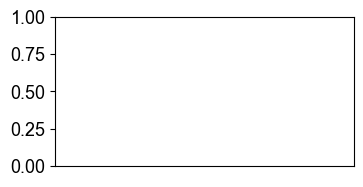

In [6]:
from palettable.lightbartlein.diverging import BlueDarkRed18_18
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pylab as pylab
params = {'legend.fontsize': 13,
          #'figure.figsize': (15, 5),
         'axes.labelsize': 13,
         'axes.titlesize':13,
         'xtick.labelsize':13,
         'ytick.labelsize':13}

pylab.rcParams.update(params)
plt.rcParams["font.family"] = "Arial"

fixed_cmap = BlueDarkRed18_18.mpl_colormap
fig = plt.figure(figsize=[16, 6])

# Use tight_layout with adjusted parameters to reduce space
plt.subplots_adjust(wspace=0.05, hspace=0.05)

# True resistivity model
for i in range(12):
    row, col = i // 4, i % 4
    ax = fig.add_subplot(3, 4, i+1)
    
    # Add common ylabel only to leftmost panels
    ylabel = "Elevation (m)" if col == 0 else None
    
    # Add resistivity label only to the middle-right panel (row 1, col 3)
    resistivity_label = ' Resistivity ($\Omega$ m)' if (i == 7) else None
    
    # Only show axis ticks on leftmost and bottom panels
    if col != 0:
        ax.set_yticks([])
    
    if row != 2:  # Not bottom row
        ax.set_xticks([])
    else:
        # Add "distance (m)" label to bottom row panels
        ax.set_xlabel("Distance (m)")
    
    # Create the plot
    ax, cbar = pg.show(result.mesh,
                      result.final_models[:,i][result.mesh.cellMarkers()],
                      pad=0.3,
                      orientation="vertical",
                      cMap=fixed_cmap,
                      cMin=100,
                      cMax=3000,
                      ylabel=ylabel,
                      label=resistivity_label,
                      ax=ax,
                      logScale=False,
                      coverage=result.all_coverage[i][result.mesh.cellMarkers()]>-1.2)
    if i ==0:
        ax.plot([40],[1607],'*',c='k')
        ax.plot([80],[1621],'*',c='k')

        ax.plot([30],[1604],'*',c='k')
        ax.plot([65],[1608],'*',c='k')
        
    # Only keep colorbar for the middle-right panel (row 1, col 3)
    # This corresponds to panel index 7 in a 0-based indexing system
    if i != 7:  # Keep only the colorbar for panel 7
        cbar.remove()

plt.tight_layout()
plt.savefig("C:/Users/HChen8/Documents/GitHub/PyHydroGeophysX/examples/results/Structure_WC/timelapse_ert_with structure.tiff", dpi=300, bbox_inches='tight')

In [7]:
temp_marker = mesh_with_interface.cellMarkers()
index_marker = temp_marker[temp_marker != 1]
np.save("C:/Users/HChen8/Documents/GitHub/PyHydroGeophysX/examples/results/Structure_WC/index_marker.npy", index_marker)
pg.show(result.mesh,index_marker,cmap="viridis",clim=(0,1e4),showMesh=True)

NameError: name 'mesh_with_interface' is not defined

In [8]:
result.final_models.shape

NameError: name 'result' is not defined

In [9]:
result.mesh.cellMarkers()

NameError: name 'result' is not defined

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pygimli as pg

# Import the resistivity_to_saturation function from your module
from watershed_geophysics.petrophysics.resistivity_models import resistivity_to_saturation

# Extract the inverted resistivity values
resistivity_values = result.final_models[result.mesh.cellMarkers(),:]

# Extract cell markers from the mesh (to identify different geological layers)
cell_markers = index_marker.copy()

# Define different parameters for each layer
# Layer 1 parameters (top layer - marker 2)
layer1_params = {
    'rhos': 100.0,     # Saturated resistivity (ohm-m)
    'n': 2.2,          # Saturation exponent
    'sigma_sur': 1/500  # Surface conductivity (S/m)
}

# Layer 2 parameters (bottom layer - marker 3)
layer2_params = {
    'rhos': 500.0,     # Saturated resistivity (ohm-m)
    'n': 1.8,          # Saturation exponent
    'sigma_sur': 0 # Surface conductivity (S/m)
}

# Define porosity values for each cell based on layer
porosity = np.zeros_like(cell_markers, dtype=float)
porosity[cell_markers == 2] = 0.30  # Top layer porosity
porosity[cell_markers == 3] = 0.25  # Bottom layer porosity

# Create arrays to store water content and saturation results
water_content = np.zeros_like(resistivity_values)
saturation = np.zeros_like(resistivity_values)

# Process each timestep
for t in range(resistivity_values.shape[1]):
    # Extract resistivity for this timestep
    resistivity_t = resistivity_values[:, t]
    
    # Process each layer separately
    # Layer 1 (marker 2)
    mask_layer1 = cell_markers == 2
    if np.any(mask_layer1):
        saturation[mask_layer1, t] = resistivity_to_saturation(
            resistivity_t[mask_layer1],
            layer1_params['rhos'],
            layer1_params['n'],
            layer1_params['sigma_sur']
        )
    
    # Layer 2 (marker 3)
    mask_layer2 = cell_markers == 3
    if np.any(mask_layer2):
        saturation[mask_layer2, t] = resistivity_to_saturation(
            resistivity_t[mask_layer2],
            layer2_params['rhos'],
            layer2_params['n'],
            layer2_params['sigma_sur']
        )
    
    # Convert saturation to water content (water_content = saturation * porosity)
    water_content[:, t] = saturation[:, t] * porosity

ModuleNotFoundError: No module named 'watershed_geophysics'

In [11]:
np.min((resistivity_t[mask_layer2]/500.0) ** (-1.8))

NameError: name 'resistivity_t' is not defined

In [12]:
np.max((resistivity_t[mask_layer2]/500.0) ** (-1.8))

NameError: name 'resistivity_t' is not defined

In [13]:
saturation[mask_layer2, 11]

NameError: name 'saturation' is not defined

NameError: name 'result' is not defined

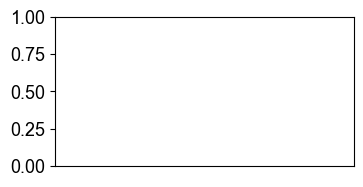

In [14]:
from palettable.lightbartlein.diverging import BlueDarkRed18_18
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pylab as pylab
params = {'legend.fontsize': 13,
          #'figure.figsize': (15, 5),
         'axes.labelsize': 13,
         'axes.titlesize':13,
         'xtick.labelsize':13,
         'ytick.labelsize':13}

pylab.rcParams.update(params)
plt.rcParams["font.family"] = "Arial"

fixed_cmap = BlueDarkRed18_18.mpl_colormap
fig = plt.figure(figsize=[16, 6])

# Use tight_layout with adjusted parameters to reduce space
plt.subplots_adjust(wspace=0.05, hspace=0.05)

# True resistivity model
for i in range(12):
    row, col = i // 4, i % 4
    ax = fig.add_subplot(3, 4, i+1)
    
    # Add common ylabel only to leftmost panels
    ylabel = "Elevation (m)" if col == 0 else None
    
    # Add resistivity label only to the middle-right panel (row 1, col 3)
    resistivity_label = ' Resistivity ($\Omega$ m)' if (i == 7) else None
    
    # Only show axis ticks on leftmost and bottom panels
    if col != 0:
        ax.set_yticks([])
    
    if row != 2:  # Not bottom row
        ax.set_xticks([])
    else:
        # Add "distance (m)" label to bottom row panels
        ax.set_xlabel("Distance (m)")
    
    # Create the plot
    ax, cbar = pg.show(result.mesh,
                      saturation[:, i],
                      pad=0.3,
                      orientation="vertical",
                      cMap='Blues',
                      cMin=0,
                      cMax=1,
                      ylabel=ylabel,
                      label=resistivity_label,
                      ax=ax,
                      logScale=False,
                      coverage=result.all_coverage[i][result.mesh.cellMarkers()]>-1.2)
    
    # Only keep colorbar for the middle-right panel (row 1, col 3)
    # This corresponds to panel index 7 in a 0-based indexing system
    if i != 7:  # Keep only the colorbar for panel 7
        cbar.remove()

plt.tight_layout()
plt.savefig("C:/Users/HChen8/Documents/GitHub/PyHydroGeophysX/examples/results/TL_measurements/appres/timelapse_sat.tiff", dpi=300, bbox_inches='tight')

In [15]:
# Create a time-series plot to show water content changes over time
def extract_time_series(mesh, values, x_positions):
    """Extract time series at specific x positions"""
    time_series = []
    for x_pos in x_positions:
        # Find closest cell to this position
        cell_idx = np.argmin(np.abs(mesh.cellCenters()[:, 0] - x_pos))
        time_series.append(values[cell_idx, :])
    return time_series

# Define positions to sample (adjust based on your model dimensions)
x_positions = [20, 40, 60, 80]
time_series = extract_time_series(mesh_with_interface, water_content, x_positions)

# Plot time series
plt.figure(figsize=(10, 6))
for i, x_pos in enumerate(x_positions):
    plt.plot(measurement_times, time_series[i], 'o-', label=f'x={x_pos}m')
plt.xlabel('Time (days)')
plt.ylabel('Water Content')
plt.title('Water Content Time Series at Selected Locations')
plt.legend()
plt.grid(True)
plt.tight_layout()

NameError: name 'mesh_with_interface' is not defined